# Data Analysis - MODS207
## Authors: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

The goal of this notebook is to explore the collected data, visualize it to acquire insights, and run regression models.

### Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read processed data
df_cities_static = pd.read_csv('../data/proc_data/cities_static.csv.zip', index_col=0)
df_cities_temp = pd.read_csv('../data/proc_data/cities_temp.csv.zip', parse_dates=[3], index_col=0)

In [3]:
# merge important data into one dataframe
df_cities_temp['city_code'] = df_cities_temp['city_code'].astype(int)
df = pd.merge(df_cities_temp, df_cities_static[['city_code', 'population']], on='city_code', how='left')

In [4]:
# prepare withdrawal data to account for the delayed effect of covid contamination
days_to_confirmation_avg = 20
days_to_confirmation_std = 4

# shift withdrawal dates
shifted_withdrawal = pd.DataFrame()
shifted_withdrawal['withdrawal_lagged'] = df['withdrawal']
shifted_withdrawal['city_code'] = df['city_code']
dates = df['date']
shifted_withdrawal['date'] = dates + pd.Timedelta(days=days_to_confirmation_avg)
df = pd.merge(df, shifted_withdrawal, on=['city_code', 'date'], how='left')

#apply gaussian smoothing
df['withdrawal_lagged_smooth'] = df.groupby('city_code')['withdrawal_lagged'].rolling(
    60,
    min_periods=1,
    win_type='gaussian',
    center=True
).mean(std=days_to_confirmation_std).values

In [5]:
# smooth covid variables
df['confirmed_day_smooth'] = df.groupby('city_code')['confirmed_day'].rolling(window=15).mean().values
df['deaths_day_smooth'] = df.groupby('city_code')['deaths_day'].rolling(window=15).mean().values

In [6]:
# add state dummy variable
df['is_SP'] = df['state'] == 'SP'

#### Filtering

For the following analyses, we will only consider cities with more than 100.000 population, since they convey the cities that were mostly affected by the Covid-19 pandemic. Additionally, we will only consider data entries that registered more than one case of Covid-19 per day and with a social withdrawal index higher than 30%.

In [7]:
# apply filtering conditions
mask = (df['population'] > 100000) & (df['confirmed_day'] > 0) & (df['withdrawal'] > 0.4)
df = df[mask]

# drop NaN values from dataset
df.dropna(inplace=True)

### Descriptive Data Statistics

#### Number of Instances: 

For this part of the study, we will consider cities in the brazilian states of São Paulo and Bahia, where we have municipality level data. Note that not all dates are available for all cities, so we're going to give some descriptive stats on the time frame as well.

In [8]:
print('Total number of instances:', len(df))
print('Number of cities:', len(df['city_code'].unique()))

dates_descriptive = df['date'].describe(datetime_is_numeric=False)
print('Number of unique dates:',  dates_descriptive['unique'])
print('Date range:', dates_descriptive['first'].date(), 'to', dates_descriptive['last'].date())

Total number of instances: 12216
Number of cities: 97
Number of unique dates: 325
Date range: 2020-03-19 to 2021-02-26


#### Descriptive Statistics by Variable:

##### Covid Variables:

In [9]:
covid_df = df[[
    'confirmed_day',
    'deaths_day',
]].div(df['population'], axis=0)*100000

covid_df.rename(
    columns={'confirmed_day': 'daily cases (per 100000)', 'deaths_day': 'daily deaths (per 100000)'},
    inplace=True
)

covid_df.describe()

,daily cases (per 100000),daily deaths (per 100000)
count,12216.000000,12216.000000
mean,13.387140,0.417540
std,16.851666,0.783865
min,0.073212,0.000000
25%,2.871799,0.000000
50%,7.695909,0.000000
75%,17.201087,0.641849
max,363.412696,17.498873


##### Telecommunication Variables:

In [10]:
telecom_df = df[[
    'cable_tv_accesses',
    'fixed_bandwidth_accesses',
    'fixed_telephony_accesses',
    '2G_mobile_accesses',
    '3G_mobile_accesses',
    '4G_mobile_accesses'
]].div(df['population'], axis=0)*100000

telecom_df.rename(
    columns={col_name: (col_name + ' (per 100000)') for col_name in telecom_df.columns},
    inplace=True
)

telecom_df.describe()

,cable_tv_accesses (per 100000),fixed_bandwidth_accesses (per 100000),fixed_telephony_accesses (per 100000),2G_mobile_accesses (per 100000),3G_mobile_accesses (per 100000),4G_mobile_accesses (per 100000)
count,12216.000000,12216.000000,12216.000000,12216.000000,12216.000000,12216.000000
mean,10951.707379,22432.067312,39083.566663,14918.084227,22046.882124,90420.909089
std,5814.543110,8201.739808,16752.773578,54587.122190,38268.224098,28140.232491
min,834.173703,3618.298047,5133.939665,2495.117796,3489.217601,37405.472223
25%,6420.159501,16484.127453,29406.119259,4646.719025,8408.664741,74564.562792
50%,10775.305433,22420.759988,36977.627400,5963.361626,9603.515869,81015.153567
75%,15086.133553,28874.524392,48499.978783,8936.064728,13542.882147,95730.202099
max,28899.174745,42785.836843,114025.122924,938882.663856,462844.905752,333226.312785


##### Social Withdrawal

In [11]:
withdrawal_df = df[[
    'withdrawal'
]].div(df['population'], axis=0)

telecom_df.describe()

,cable_tv_accesses (per 100000),fixed_bandwidth_accesses (per 100000),fixed_telephony_accesses (per 100000),2G_mobile_accesses (per 100000),3G_mobile_accesses (per 100000),4G_mobile_accesses (per 100000)
count,12216.000000,12216.000000,12216.000000,12216.000000,12216.000000,12216.000000
mean,10951.707379,22432.067312,39083.566663,14918.084227,22046.882124,90420.909089
std,5814.543110,8201.739808,16752.773578,54587.122190,38268.224098,28140.232491
min,834.173703,3618.298047,5133.939665,2495.117796,3489.217601,37405.472223
25%,6420.159501,16484.127453,29406.119259,4646.719025,8408.664741,74564.562792
50%,10775.305433,22420.759988,36977.627400,5963.361626,9603.515869,81015.153567
75%,15086.133553,28874.524392,48499.978783,8936.064728,13542.882147,95730.202099
max,28899.174745,42785.836843,114025.122924,938882.663856,462844.905752,333226.312785


### Visualizations and Analyses

#### Social Isolation Effect on the Covid-19 Pandemic

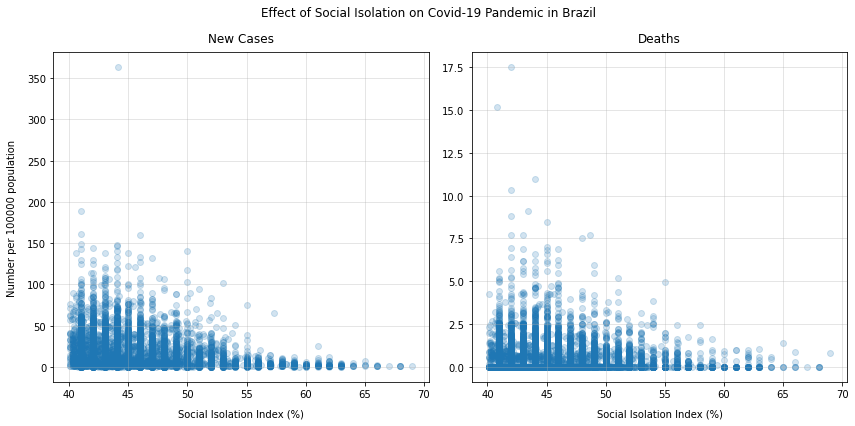

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

new_cases_pc = df['confirmed_day'].div(df['population'])
deaths = df['deaths_day'].div(df['population'])
withdrawal = df['withdrawal']

ax1.scatter(withdrawal*100, new_cases_pc*100000, alpha=0.2)
ax1.set_xlabel('Social Isolation Index (%)', labelpad=10)
ax1.set_ylabel('Number per 100000 population', labelpad=10)
ax1.set_title('New Cases', pad=10)
ax1.grid(alpha=0.4)

ax2.scatter(withdrawal*100, deaths*100000, alpha=0.2)
ax2.set_xlabel('Social Isolation Index (%)', labelpad=10)
ax2.set_title('Deaths', pad=10)
ax2.grid(alpha=0.4)

fig.suptitle('Effect of Social Isolation on Covid-19 Pandemic in Brazil')
plt.tight_layout()
plt.show()

In this study, we use the social isolation index as a proxy for how the population is respecting social distance, and as a result of governmental policies. We can see that for social isolation ratings higher than 40%, both the number of new daily cases and the number of deaths are inversely correlated with isolation. This shows that social distance is indeed positive for containing the spread of the virus.

However, if we look at the death and new cases rates at the lower end of the isolation index, we notice a positive correlation. This may be due to the fact that when the number of cases is low, people start to go out and the government loosens restrictions, leading to an increase in the number of cases.

### Regressions

#### Removing Serial Autocorrelation from Withdrawal

We can verify that the social withdrawal index is serially autocorrelated. Let's visualize this autocorrelation for the city of Salvador.

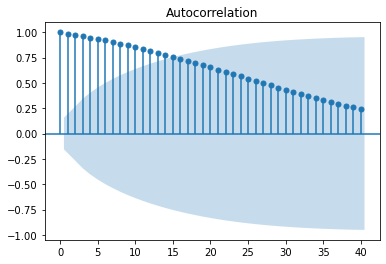

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df[df['city_name'] == 'SALVADOR']['withdrawal_lagged_smooth'], lags=40)
plt.show()

We can correct this issue by using the first difference of the social withdrawal. Let's apply this to our data and visualize autocorrelation.

In [14]:
df['withdrawal_diff'] = df.groupby(['city_code'])['withdrawal_lagged_smooth'].diff().values

In [15]:
# drop NaN values from dataset
df.dropna(inplace=True)

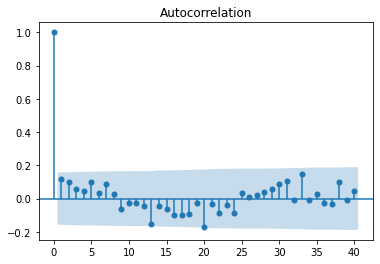

In [16]:
plot_acf(df[df['city_name'] == 'SALVADOR']['withdrawal_diff'], lags=40)
plt.show()

We can see that this technique significantly reduced autocorrelation. 

#### Panel OLS - Deaths per capita x Social Withdrawal

Let's start by comparing how the social isolation index affects on the number of deaths per capita by Covid-19. Initially, we're going to apply a Panel OLS with municipality time constant effects and time varying effects. In this case, the municipality time-constant effects would account for how each municipality dealed with the pandemics (specific measures by the city council and cultural particularities of each city). The time effects account for evolutions in the treatment of Covid-19, such as early detection of the desease and improved medical care.

In [60]:
y = df.loc[:,['city_code', 'date']]
y['deaths_day_pc'] = df['deaths_day_smooth'].div(df['population'])
y.set_index(['city_code', 'date'], inplace=True)

In [61]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_diff']])
X.set_index(['city_code', 'date'], inplace=True)

In [62]:
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          deaths_day_pc   R-squared:                        0.0006
Estimator:                   PanelOLS   R-squared (Between):             -0.0418
No. Observations:               12119   R-squared (Within):              -0.0022
Date:                Mon, May 31 2021   R-squared (Overall):             -0.0017
Time:                        15:46:09   Log-likelihood                  1.39e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.3149
Entities:                          97   P-value                           0.0068
Avg Obs:                       124.94   Distribution:                 F(1,11699)
Min Obs:                       34.000                                           
Max Obs:                       264.00   F-statistic (robust):             1.2829
                            

Here, we can see that the withdrawal has an inversely correlated effect with the number of deaths, which is not statistically significant.

Now, instead of using municipality time-constant effects in our model, we will use state effects. The reasoning for this change is that, in Brazil, Covid containment measures are defined by State governments, and therefore all municipalities are subject to state regulations.

In [54]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_diff', 'is_SP']])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       confirmed_day_pc   R-squared:                        0.0210
Estimator:                   PanelOLS   R-squared (Between):              0.1328
No. Observations:               12119   R-squared (Within):              -0.0022
Date:                Mon, May 31 2021   R-squared (Overall):              0.0168
Time:                        15:44:52   Log-likelihood                 9.601e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      126.53
Entities:                          97   P-value                           0.0000
Avg Obs:                       124.94   Distribution:                 F(2,11794)
Min Obs:                       34.000                                           
Max Obs:                       264.00   F-statistic (robust):             80.694
                            

In this case, we can see that the withdrawal variable did not change much, but there is a clear difference between the two states in terms of new cases per capita. As we can see, cities in the state of São Paulo have a statistically significant larger number of cases per capita.

#### Panel OLS - Deaths per capita x (Telecommunications + Social Withdrawal)

Now, let's continue the analysis by including telecommunications infrastructure variables into the model.

In [63]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_diff']])

X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X['4G_mobile'] = df['4G_mobile_accesses'].div(df['population'])
X['3G_mobile'] = df['3G_mobile_accesses'].div(df['population'])
X['2G_mobile'] = df['2G_mobile_accesses'].div(df['population'])
X['fixed_telephony'] = df['fixed_telephony_accesses'].div(df['population'])

X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          deaths_day_pc   R-squared:                        0.0036
Estimator:                   PanelOLS   R-squared (Between):              0.0164
No. Observations:               12119   R-squared (Within):              -0.0111
Date:                Mon, May 31 2021   R-squared (Overall):              0.0028
Time:                        15:46:45   Log-likelihood                 1.391e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.0640
Entities:                          97   P-value                           0.0000
Avg Obs:                       124.94   Distribution:                 F(7,11693)
Min Obs:                       34.000                                           
Max Obs:                       264.00   F-statistic (robust):             4.3764
                            

For this regression, when using state-level entity effects, we get positive correlations for all the telecommunications variables. This can be due to state-level effects not being able to account for differences between municipalities. 

When using city-level effects, however, we find that only two telecommunications variables are significant on the 5% confidence level - cable television and fixed telephony. The effect of Cable TV is statistically significant and negatively correlated to the number of deaths, which can indicate that having access to cable television contributes to the spread of information and the containment of the virus. On the other hand, a high number of fixed telephony accesses per capita indicates a higher number of Covid-19 deaths per capita. This is probably due to the fact that cities without modern telecom infrastructure tend to use this service more, and since fixed telephony is not a really an effective mechanism for spreading information nowadays, this can damage containment measures.